# CSE 258, Fall 2019: Homework 2

Polish Backruptcy data: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

## Tasks - Diagnotics (week 2):
In the first homework, we had two issues with the classifiers we built. Namely (1) the data were not shuffled, and (2) the labels were highly imbalanced. Both of these made it difficult to effectively build an accurate classifier. Here we’ll try and correct for those issues using the Bankruptcy dataset.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt
random.seed(3)

### Task 1 
Download and parse the bankruptcy data. We’ll use the 5year.arff file. Code to read the data is available in the stub. Train a logistic regressor (e.g. sklearn.linear model.LogisticRegression) with regularization coefficient C = 1.0. Report the accuracy and Balanced Error Rate (BER) of your classifier (1 mark).

In [2]:
f = open("./data/5year.arff", 'r')

# Reading in data - removing the first rows with attribute info
while not '@data' in f.readline():
    pass

dataset = []
for l in f:
    if '?' in l: # Missing entry
        continue
    l = l.split(',')
    values = [1] + [float(x) for x in l]
    values[-1] = values[-1] > 0 # Convert to bool
    dataset.append(values)

# Data setup
X = [d[:-1] for d in dataset]
y = [d[-1] for d in dataset]

$BER = \frac{1}{2} (FPR + FNR)$   
$BER =  1 - \frac{1}{2} (TPR + TNR)$   
$BER = 1 - \frac{1}{2} \cdot (\frac{TP}{TP + FN} + \frac{TN}{TN + FP})$   

BER should be around 0.5 for a random classifier, and 0 for a perfect classifier.

In [3]:
def get_truth(X, y, model):
    pred = model.predict(X)
    correct = pred == y
    # True positives, false positives, etc.
    TP_ = np.logical_and(pred, y)
    FP_ = np.logical_and(pred, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(pred), y)
    return sum(TP_), sum(FP_), sum(TN_), sum(FN_)

def get_accuracy_and_BER(X, y, model):
    TP, FP, TN, FN = get_truth(X, y, model)
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    TPR = TP / (TP + FN) # True positive rate
    TNR = TN / (TN + FP) # True negative rate
    BER = 1 - 0.5 * (TPR + TNR) # Balanced Error Rate
    return accuracy, BER

In [4]:
model = LogisticRegression(C=1.0, solver="lbfgs")
model.fit(X, y)
accuracy, BER = get_accuracy_and_BER(X, y, model)
print("Model fit and test on whole dataset")
print("Accuracy: {}".format(accuracy))
print("Balanced Error Rate: {}".format(BER))

Model fit and test on whole dataset
Accuracy: 0.9656878917848895
Balanced Error Rate: 0.4766851431593464


### Task 2
Retrain the above model using the class weight=’balanced’ option. Report the accuracy and BER of your new classifier (1 mark).

In [5]:
model = LogisticRegression(C=1.0, solver="lbfgs", class_weight="balanced")
model.fit(X, y)
accuracy, BER = get_accuracy_and_BER(X, y, model)
print("Model fit and test on whole dataset")
print("Accuracy: {}".format(accuracy))
print("Balanced Error Rate: {}".format(BER))

Model fit and test on whole dataset
Accuracy: 0.6958099637083471
Balanced Error Rate: 0.304060477041619


### Task 3
Shuffle the data, and split it into training, validation, and test splits, with a 50/25/25% ratio. Using the class weight=’balanced’ option, and training on the training set, report the training/validation/test accuracy and BER (1 mark).

In [6]:
def train_val_test_split(X, y, ratio=(0.5,0.25,0.25), shuffle=True):
    if shuffle:
        Xy = list(zip(X,y))
        random.shuffle(Xy)

        X = [d[0] for d in Xy]
        y = [d[1] for d in Xy]

    N = len(y)
    
    assert len(ratio) == 3 and sum(ratio) == 1.0
    
    Ntrain = round(N*ratio[0])
    Nvalid = round(N*ratio[1])
    Ntest = round(N*ratio[2])

    Xtrain, ytrain = X[:Ntrain], y[:Ntrain]
    Xvalid, yvalid = X[Ntrain:Ntrain+Nvalid], y[Ntrain:Ntrain+Nvalid]
    Xtest, ytest = X[Ntrain+Nvalid:], y[Ntrain+Nvalid:]

    return Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest

In [7]:
Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = train_val_test_split(X,y)

model = LogisticRegression(C=1.0, class_weight="balanced", solver="lbfgs")
model.fit(Xtrain, ytrain)

print("(TRAINING) Accuracy: {}, BER: {}".format(*get_accuracy_and_BER(Xtrain, ytrain, model)))
print("(VALIDATION) Accuracy: {}, BER: {}".format(*get_accuracy_and_BER(Xvalid, yvalid, model)))
print("(TEST) Accuracy: {}, BER: {}".format(*get_accuracy_and_BER(Xtest, ytest, model)))

(TRAINING) Accuracy: 0.6978891820580475, BER: 0.30200286307535573
(VALIDATION) Accuracy: 0.6846965699208444, BER: 0.32406151062867483
(TEST) Accuracy: 0.7199471598414795, BER: 0.26560356652949246


### Task 4
Implement a complete regularization pipeline. Consider values of C in the range {10−4, 10−3, . . . , 10^3, 10^4}. Report (or plot) the train, validation, and test BER for each value of C. Based on these values, which classifier would you select (in terms of generalization performance) and why (1 mark)?

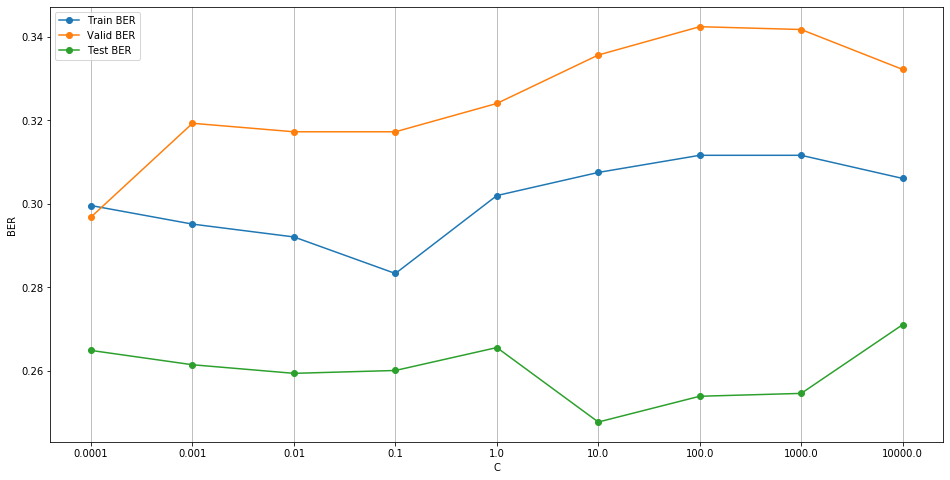

In [8]:
cs = [10**(-4) * 10**(x) for x in range(0, 9)]
train_BER, valid_BER, test_BER = [], [], []
for c in cs:
    model = LogisticRegression(C=c, class_weight="balanced", solver="lbfgs")
    model.fit(Xtrain, ytrain)
    train_BER.append(get_accuracy_and_BER(Xtrain,ytrain, model)[1])
    valid_BER.append(get_accuracy_and_BER(Xvalid,yvalid, model)[1])
    test_BER.append(get_accuracy_and_BER(Xtest,ytest, model)[1])



x = np.arange(0, len(cs))
plt.figure(figsize=(16,8))
plt.plot(x, train_BER, marker="o",label="Train BER")
plt.plot(x, valid_BER, marker="o", label="Valid BER")
plt.plot(x, test_BER, marker="o", label="Test BER")
plt.xticks(ticks=x, labels=cs)
plt.legend(loc="best")
plt.xlabel("C")
plt.ylabel("BER")
plt.gca().xaxis.grid(True)
plt.show()

We should choose the classifier that reports the lowest BER on the valdation set. From the graph we can see that the lowest BER for the valdation set is when C = 0.0001, but by looking at the test graph, we see that it performes best when C is set to be equal 10. If we are going to make our choice based on what is shown by the validation set, we choose 0.0001 as the best option for C. 

### Task 5
Compute the Fβ scores for β = 1, β = 0.1, and β = 10 for the above classifier, using C = 1 (on the test set) (1 mark).

$F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\beta^2precision + recall}$   
where  
$Precision = \frac{TP}{TP + FP}$ & 
$Recall = \frac{TP}{TP + FN}$

If precision is more important you should use a low beta, and if recall is more important you should use a high beta.

Note: In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a 
test’s accuracy. ( a type I error is detecting an effect that is not present, while a type II error is failing to 
detect an effect that is present. The terms “type I error” and “type II error” are often used interchangeably with 
the general notion of false positives and false negatives ). Fβ “measures the effectiveness of retrieval with 
respect to a user who attaches β times as much importance to recall as precision”

In [9]:
# from sklearn.metrics import fbeta_score
def f_beta(X, y, model, beta):
    TP, FP, TN, FN = get_truth(X, y, model)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return ((1 + beta**2) * (precision*recall) / (beta**2*precision + recall))

model = LogisticRegression(C=1.0, solver="lbfgs")
model.fit(Xtrain, ytrain)
pred = model.predict(Xtest)
for beta in [1, 0.1, 10]:
    score = f_beta(Xtest, ytest, model, beta)
    # score = fbeta_score(ytest, pred, beta) Gives same results with sklearn
    print("(beta={}) F_beta score: {}".format(beta, score))


(beta=1) F_beta score: 0.12121212121212122
(beta=0.1) F_beta score: 0.38257575757575757
(beta=10) F_beta score: 0.07201426024955437


### Task 6 
The sample weight option allows you to manually build a balanced (or imbalanced) classifier by assigning different weights to each datapoint (i.e., each label y in the training set). For example, we would assign equal weight to all samples by fitting:

```
weights = [1.0 * len(ytrain)]
mod = linear_model.LogisticRegression(C=1, solver=’lbfgs’) mod.fit(Xtrain, ytrain, sample_weight=weights)
```

(note that you should use the lbfgs solver option, and need not set class weight=’balanced’ in
this case). Assigning larger weights to (e.g.) positive samples would encourage the logistic regressor to
optimize for the True Positive Rate. Using the above code, compute the Fβ score (on the test set) of your
(unweighted) classifier, for β = 1 and β = 10. Following this, identify weight vectors that yield better
performance (compared to the unweighted vector) in terms of the F1 and F10 scores (2 marks)

In [19]:
# Unweighted classifier
model = LogisticRegression(C=1.0, solver="lbfgs")
model.fit(Xtrain, ytrain)

for beta in [1, 10]:
    score = f_beta(Xtest, ytest, model, beta)
    print("(beta={}, unweighted) F_beta score: {}".format(beta, score))

# Make some assumptions about how each sample, an example is asigning larger weights to 
# e.g. positive samples would encourage the logistic regressor to optimize for the
# True Positive Rate.
ratio = 0.95

weights = [ratio if label else 1-ratio for label in ytrain]
model = LogisticRegression(C=1.0, solver="lbfgs")
model.fit(Xtrain, ytrain, sample_weight=weights)

for beta in [1, 10]:
    score = f_beta(Xtest, ytest, model, beta)
    print("(beta={}, weighted) F_beta score: {}".format(beta, score))
print()


(beta=1, unweighted) F_beta score: 0.12121212121212122
(beta=10, unweighted) F_beta score: 0.07201426024955437
(beta=1, weighted) F_beta score: 0.25757575757575757
(beta=10, weighted) F_beta score: 0.5912534435261707



A weight ratio of 0.95 for True labels seems to be a reasonable value. We get a higher F1 and F10 score which means that we are getting better results for both presicion and recall. By increasing the ratio even more, we will do even better on recal, but this will affect the precission to go down, which makes sence. You have to decide what is most important for your model; precission (the fraction of relevant instances among the retrieved instances) or recall (the fraction of the total amount of relevant instances that were actually retrieved)

## Tasks - Dimensionality Reduction (week 3):
Next we’ll consider using PCA to build a lower-dimensional feature vector to do prediction.

In [20]:
import scipy.optimize
import random
from sklearn.decomposition import PCA
from collections import defaultdict

### Task 7
Following the stub code, compute the PCA basis on the training set. Report the first PCA component
(i.e., pca.components [0]) (1 mark).

In [21]:
# Code Here
pca = PCA()
pca.fit(Xtrain)
print("First PCA component:\n", pca.components_[0])

First PCA component:
 [-5.13677730e-19  1.71415335e-07 -7.56809402e-07  8.93429002e-07
  4.56333172e-06  2.11142581e-03  7.18604285e-07  1.93926201e-07
  5.22832850e-06 -5.00680231e-07  6.90386976e-07  1.41939772e-07
  1.07342084e-06 -5.41089021e-06  1.93564447e-07  3.35059096e-03
  1.03688064e-06  5.84540069e-06  6.06035215e-08  2.68542628e-07
  1.86083514e-05  2.23716898e-08  1.25273278e-07  2.42397290e-07
  4.23787533e-07  8.87867319e-07  9.06633416e-07 -5.03192530e-05
  1.88265640e-06  3.87204723e-06 -1.29643683e-06  2.42706535e-07
 -2.44089242e-04  3.65488804e-06 -2.07544846e-06  1.15319121e-07
 -6.65021815e-07  4.94819674e-03  6.01908946e-07  1.72473553e-07
  2.57476360e-06 -1.72547485e-06  1.03734514e-07  4.10472953e-05
  2.24369027e-05 -2.86133990e-06  3.65473372e-06  2.72545581e-05
  1.75123150e-07  2.22116764e-07  4.14763532e-06 -6.13148328e-07
 -6.50785456e-07 -4.44899253e-06  1.79688686e-06  9.99979847e-01
  1.39800723e-07  3.73174151e-07 -2.19633018e-07  9.44642971e-08
 -1

### Task 8
Next we’ll train a model using a low-dimensional feature vector. By representing the data in the above
basis, i.e.:

```
Xpca_train = numpy.matmul(Xtrain, pca.components_.T) 
Xpca_valid = numpy.matmul(Xvalid, pca.components_.T) 
Xpca_test = numpy.matmul(Xtest, pca.components_.T)
```

compute the validation and test BER of a model that uses just the first N components (i.e., dimensions) for N = 5, 10, . . . , 25, 30. Again use class weight=’balanced’ and C = 1.0 (2 marks).

In [22]:
N_components = np.arange(5, 35, 5)
for n in N_components:
    
    # Transform data
    Xpca_train = np.matmul(Xtrain, pca.components_[:n].T) 
    Xpca_valid = np.matmul(Xvalid, pca.components_[:n].T) 
    Xpca_test = np.matmul(Xtest, pca.components_[:n].T)
    
    # Fit model
    model = LogisticRegression(C=1.0, solver="lbfgs", class_weight="balanced")
    model.fit(Xpca_train, ytrain)
    
    acc_valid, BER_valid = get_accuracy_and_BER(Xpca_valid, yvalid, model)
    acc_test, BER_test = get_accuracy_and_BER(Xpca_test, ytest, model)
    
    print("(N=n{}) BER_valid: {}".format(n, BER_valid))
    print("(N=n{}) BER_test: {}\n".format(n, BER_test))
    

(N=n5) BER_valid: 0.3426374620404471
(N=n5) BER_test: 0.28698804624730556

(N=n10) BER_valid: 0.3809846869548362
(N=n10) BER_test: 0.3760533019792278

(N=n15) BER_valid: 0.31931252826775225
(N=n15) BER_test: 0.260116598079561

(N=n20) BER_valid: 0.3213478064224333
(N=n20) BER_test: 0.25531550068587106

(N=n25) BER_valid: 0.3417651999741551
(N=n25) BER_test: 0.25462962962962965

(N=n30) BER_valid: 0.343122052077276
(N=n30) BER_test: 0.25531550068587106

